In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
# import zscale

from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter, FlatMover
from weak_sauce.sources import Source
from weak_sauce.grid import MoveableGrid

In [3]:
hdulist = fits.open('../data/coadd_r_14.fits') #not in repo--need to put in local install's data dir

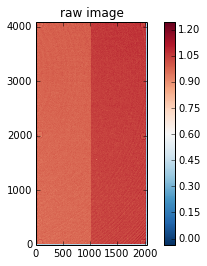

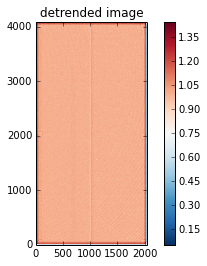

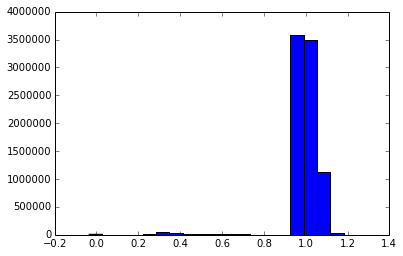

In [4]:
img = hdulist[0].data#[800:1600,1100:1900] #[700:1300,1100:1700] for DES masterflat, also use fits ext1
img = img/np.mean(img)
# [low,high] = zscale.zscale(img)
plt.imshow(img)#,vmin=low,vmax=high)
plt.colorbar()
plt.title('raw image')
plt.figure()
plt.title('detrended image')
#plot detrended image
import scipy.ndimage
klen = 100
kernel = np.ones((klen,klen))/klen**2
smoothed = scipy.ndimage.convolve(img-np.mean(img),kernel)
detrended = img-smoothed
# [low,high] = zscale.zscale(detrended)
plt.imshow(detrended)#,vmin=low,vmax=high)
plt.colorbar()
plt.figure()
_ = plt.hist(img.flatten(),bins=20)
data_rel_flux_map = img

In [6]:
data_like_source = Source(num_x=data_rel_flux_map.shape[0] + 1, num_y=data_rel_flux_map.shape[1] + 1) 
data_like_source.fluxes += 1 #fit to flat field with LL=1
#old way (before Chris' refactoring)
#data_mg = MoveableGrid(data_like_source,data_like_mover)
#fitter = FlatFitter(data_rel_flux_map, luminosity=1)
data_mg = FlatFitter(data_like_source,data_rel_flux_map,luminosity=1)
data_mg.fit(xtol=1e-9,ftol=1e-9,maxiter=10000,step_size=1e-1)
#data_mg.source.plot(data_rel_flux_map)
#plt.title('Data-Model')

maxiter reached


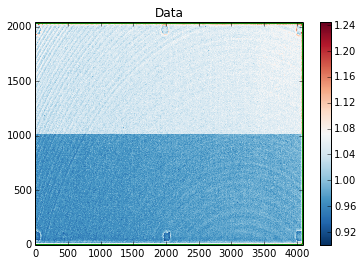

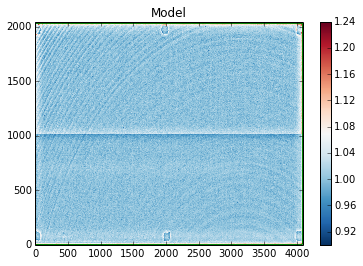

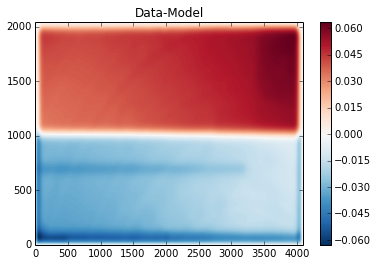

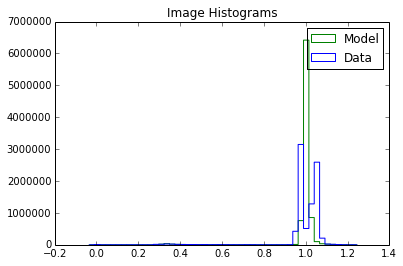

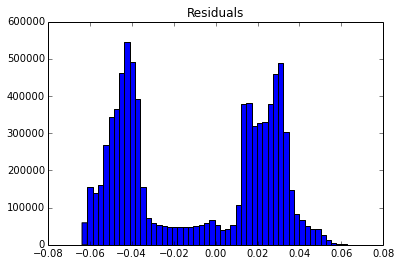

In [7]:
ZZ = np.ma.array(data_rel_flux_map.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')

ZZ = np.ma.array(data_mg.source.fluxes.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Model')

data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')

plt.figure()
plt.title('Image Histograms')
_ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)

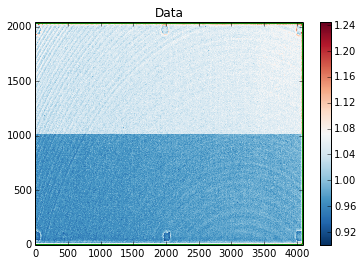

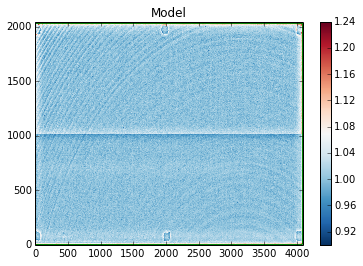

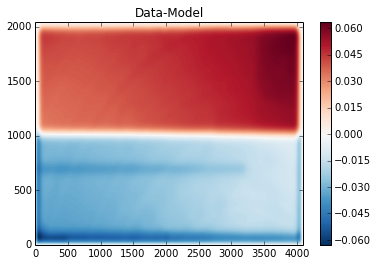

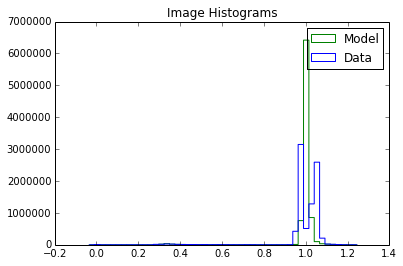

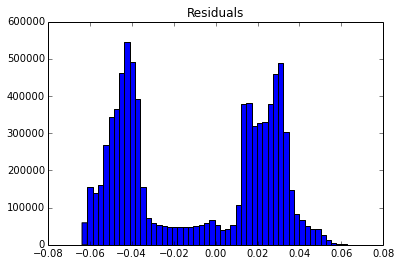

In [8]:
#chris' run on masterflat
ZZ = np.ma.array(data_rel_flux_map.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')

ZZ = np.ma.array(data_mg.source.fluxes.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Model')

data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')

plt.figure()
plt.title('Image Histograms')
_ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)

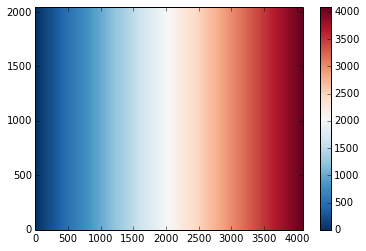

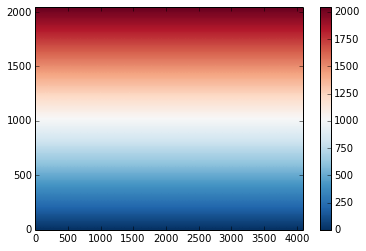

In [9]:
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, :,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, :,1],
                              pcolormesh_kwargs_in={'linewidths':0})

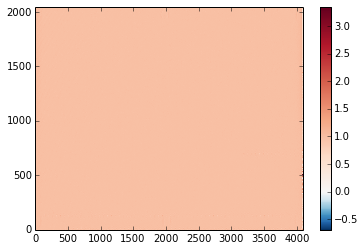

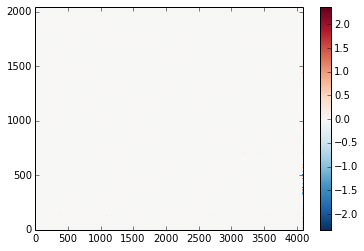

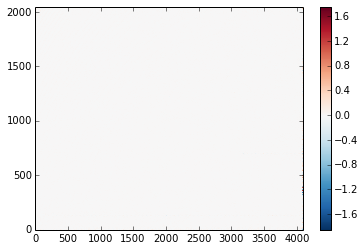

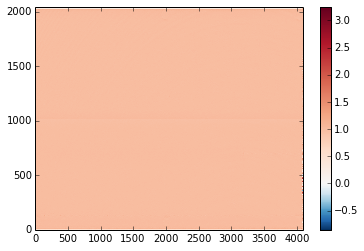

In [10]:
fig, ax = data_mg.source.plot(data_mg.source.vertices[1:, :,0] - 
                              data_mg.source.vertices[:-1, :,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, 1:,0] - 
                              data_mg.source.vertices[:, :-1,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[1:, :,1] - 
                              data_mg.source.vertices[:-1, :,1],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, 1:,1] - 
                              data_mg.source.vertices[:, :-1,1],
                              pcolormesh_kwargs_in={'linewidths':0})

Hmm, this DES flat (no detrending, 4x larger than the LSST flat) doesn't fit very well at all... Possible explanations:

* According to the FITS header, the masterFlat is composed of only 10 coadded flats, so shot noise may be preventing the convergence of the model. However, if this were the case, we'd expect a speckled pattern in the residual, which we don't.

* Maybe it needs more steps to converge/smaller step size? Maybe, but improvement from 10k steps to 20k steps was marginal...

[[ 100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.]]


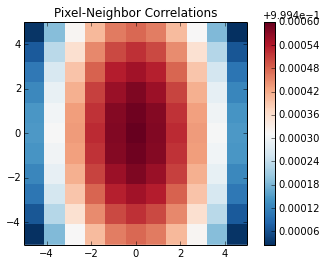

In [11]:
from weak_sauce.data_tools import makeCorr
_ = makeCorr(data_rel_flux_map - data_mg.source.fluxes, rescale_cmap=False)

[[  71.3   83.8   95.3   83.8   71.3]
 [  72.7   85.2   96.9   85.2   72.6]
 [  75.3   87.9  100.    87.9   75.3]
 [  72.6   85.2   96.9   85.2   72.7]
 [  71.3   83.8   95.3   83.8   71.3]]


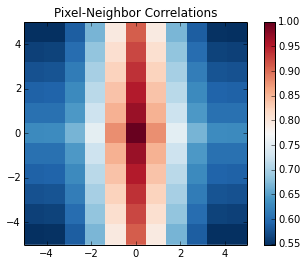

In [12]:
B = makeCorr(data_rel_flux_map, N=5, rescale_cmap=False)

[[  65.7   80.6   94.4   80.6   65.7]
 [  67.3   82.3   96.3   82.3   67.3]
 [  70.5   85.6  100.    85.6   70.5]
 [  67.3   82.3   96.3   82.3   67.3]
 [  65.7   80.6   94.4   80.6   65.7]]


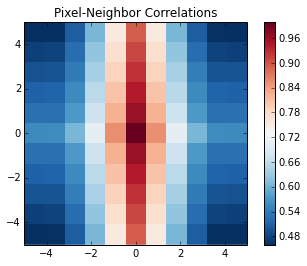

In [13]:
A = makeCorr(data_mg.source.fluxes, rescale_cmap=False)

<matplotlib.colorbar.Colorbar instance at 0x11bee54d0>

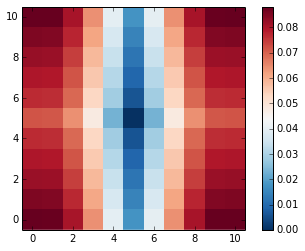

In [14]:
plt.imshow(B - A)
plt.colorbar()

The DES flat has very different correlation structure: TBC...

### Shape measurements of gaussians

In [15]:
verts = data_mg.source.vertices.copy()
simple_verts = np.dstack(np.meshgrid(
    np.linspace(0, verts.shape[0]-1, verts.shape[0], endpoint=True),
    np.linspace(0, verts.shape[1]-1, verts.shape[1], endpoint=True),
    indexing='ij'))
print(verts.shape, simple_verts.shape)

(4097, 2049, 2) (4097, 2049, 2)


In [16]:
np.random.randint(verts.shape[0]-1)

402

NameError: name 'psf2' is not defined

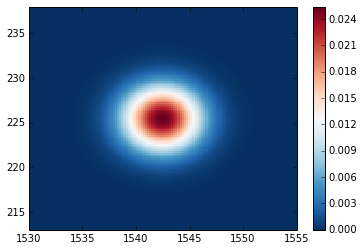

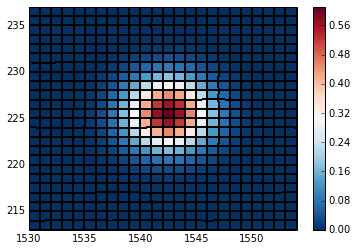

In [17]:
from weak_sauce.grid import MoveableGrid
from weak_sauce.movers import FixedIlluminationMover
# make an input source
def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
dlist = ['Mx', 'My', 'e0', 'e1', 'e2']
num_x = 25

for i in xrange(1,5):
    start_x = np.random.randint(verts.shape[0] - 1 - num_x)
    start_y = np.random.randint(verts.shape[1] - 1 - num_x)
#     print(start_x, start_y)

    mu = np.array([start_x + 0.5 * num_x, start_y + 0.5 * num_x])
    sigma = np.array([num_x * 0.1] * 2)

    stationary_source = Source(num_x=num_x*5, min_x=start_x, max_x=start_x + num_x, 
                               num_y=num_x*5, min_y=start_y, max_y=start_y + num_x,
                               flux_func=gauss, mu=mu, sigma=sigma)

    mover_fixed = FixedIlluminationMover(stationary_source)

    source_cutout = Source(num_x=num_x)  # pixel coordinates to match with stationary_souce
    source_cutout.vertices = verts[start_x:start_x + num_x, start_y:start_y + num_x].copy()


    mg = MoveableGrid(source_cutout, mover_fixed)

    mg.step()
    
    stationary_source.plot(stationary_source.fluxes,
                           stationary_source.vertices[:,:,0],
                           stationary_source.vertices[:,:,1],
                           pcolormesh_kwargs_in={'linewidths':0})
    source_cutout.plot(source_cutout.fluxes,
                       source_cutout.vertices[:,:,0],
                       source_cutout.vertices[:,:,1],
                       pcolormesh_kwargs_in={'linewidths':0.5})

    psf = mg.evaluate_psf()[dlist]
#     psf['dx'] = psf['Mx'] - mu[0] + (start_x)
#     psf['dy'] = psf['My'] - mu[1] + (start_y)
    psf['x_corner'] = start_x
    psf['y_corner'] = start_y
    
    
    # redo for a common grid
    if i == 0:
        # should ONLY need to do this once for a single gaussian
        source_cutout.vertices = simple_verts[start_x:start_x + num_x, start_y:start_y + num_x].copy()
        mg = MoveableGrid(source_cutout, mover_fixed)
        mg.step()
        psf2 = mg.evaluate_psf()[dlist]
        #psfs = psf2

    for di in dlist:
        psf['d{0}'.format(di)] = psf[di] - psf2[di]
    
    psfs = psfs.append(psf, ignore_index=True)
# psfs

In [ ]:
# now show a distribution of the d's
binnum = 50
for di in dlist + ['E', 'M']:
    key = 'd{0}'.format(di)
    if di == 'M':
        dmx = psfs['dMx']
        dmy = psfs['dMy']
        df = pd.DataFrame({'dMx': dmx, 'dMy': dmy})
        df['dMx'].hist(bins=binnum, histtype='step', figsize=(5,5), label='dMx')
        df['dMy'].hist(bins=binnum, histtype='step', label='dMy')
        plt.legend()
plt.figure()
for di in dlist + ['E', 'M']:
    key = 'd{0}'.format(di)
    if di == 'E':
        de1 = (psfs['e1'] / psfs['e0'] - (psf2['e1'] / psf2['e0']).values).values
        de2 = (psfs['e2'] / psfs['e0'] - (psf2['e2'] / psf2['e0']).values).values
        df = pd.DataFrame({'dE1': de1, 'dE2': de2})
        df['dE1'].hist(bins=binnum, histtype='step', figsize=(5,5), label='dE1')
        df['dE2'].hist(bins=binnum, histtype='step', label='dE2')
        plt.legend()
    else:
        pass
        #psfs[key].hist(bins=binnum, histtype='step')
    #plt.title(key)

In [ ]:
for di in dlist:
    plt.figure()
    key = 'd{0}'.format(di)
    psfs[key].hist(bins=binnum, histtype='step', label=key)
    plt.legend()
for di in dlist:
    plt.figure()
    key = '{0}'.format(di)
    psfs[key].hist(bins=binnum, histtype='step', label=key)
    plt.legend()

In [ ]:
(np. sqrt(2*psfs['e0'])).hist(bins=binnum, histtype='step')